1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
%matplotlib inline

Integral: 99.99999999381093
Real integral: 23.810285846323822
Ratio: 0.23810285847797458


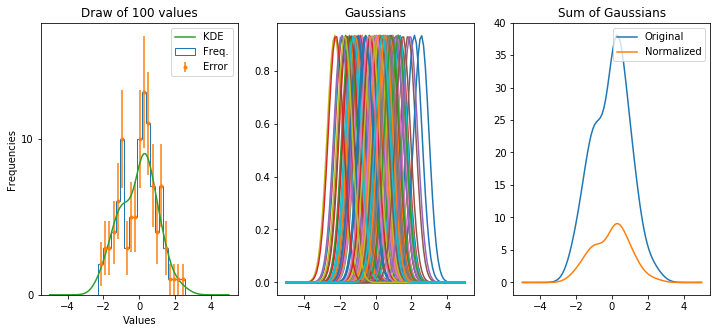

In [2]:
N = 100
mean = 0
std = 1
x = np.random.normal(mean,std,N)

# histogram
spaceSteps = 20
fig,(plotsx,plotc,plotdx) = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
y,bins,_ = plotsx.hist(x, bins=spaceSteps, histtype='step',label='Freq.')
centers = 0.5 * (bins[1:] + bins[:-1])

plotsx.set_title('Draw of {} values'.format(N))
plotsx.set_xlabel('Values')
plotsx.set_ylabel('Frequencies')
plotsx.yaxis.set_major_locator(MultipleLocator(10))
plotsx.errorbar(centers, y, yerr=y**0.5, label='Error', \
                marker='.', drawstyle='steps-mid', ls='none')

# gaussians creation
ls = np.linspace(-5, +5, num=N) # range of interest
grid = np.zeros((N,len(ls)))    # results container
stdDef = 1.06 * x.std() * x.size**(-1/5)
for i in range(len(x)):
    val = x[i]
    norm = sp.stats.norm(loc=val, scale=stdDef)
    gauss = norm.pdf(ls)
    plotc.plot(ls, gauss)
    grid[i,:] = gauss # save on a row
plotc.set_title('Gaussians')

# summing and plotting
gausSum = np.sum(grid, axis=0) # sum by columns
plotdx.plot(ls,gausSum, label='Original')
plotdx.set_title('Sum of Gaussians')

# ratio computation
integ = sp.integrate.trapz(gausSum, ls)
rInteg = sp.integrate.trapz(y, bins[1:])
normRatio = rInteg / integ
print("Integral: {}\nReal integral: {}\nRatio: {}".format(integ,rInteg,normRatio))

# normalization and plotting (on both sides)
normalized = gausSum * normRatio
plotdx.plot(ls, normalized, label='Normalized')
plotsx.plot(ls, normalized, label='KDE')
plotdx.legend(loc='upper right')
plotsx.legend();

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

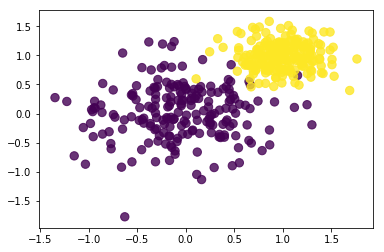

In [3]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

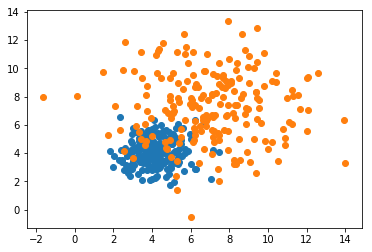

In [4]:
def scatter2d(means, stds, numPts):
    if len(means) != len(stds):
        return
    for i in range(len(means)):
        x = np.random.normal(means[i], stds[i], numPts)
        y = np.random.normal(means[i], stds[i], numPts)
        plt.scatter(x,y)

# length of these lists are not fixed:
# try with more than 2 elements
means = [4, 7]
stds  = [1.0, 2.5]
scatter2d(means,stds,200)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


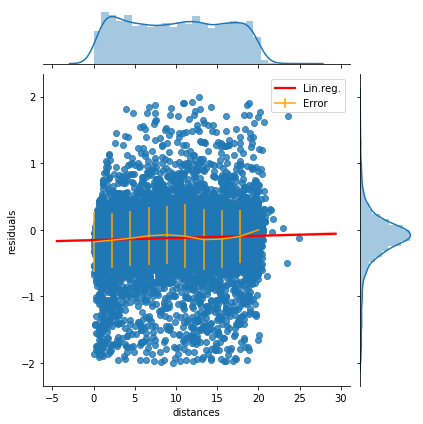

In [5]:
# dataset loading and cleaning
arr = np.load('residuals_261.npy').item()
ds = pd.DataFrame(arr)
ds = ds[ abs(ds['residuals'])<2 ]

# linear regression with plot
lr = sp.stats.linregress(ds['distances'], ds['residuals'])
sns.jointplot(ds['distances'], ds['residuals'], kind='reg',
             line_kws={'color':'red', 'label':'Lin.reg.'})

# results container and step setting
nStep = 10
x = np.linspace(0,20,nStep)
y = np.zeros(x.size)
erry = np.zeros(x.size)

cnt = 0
prevEl = x[0]
for el in x[1:]:
    # slice extraction: cannot do in single instruction so split in two
    # bDst = ds[ ds['distances']>=prevEl and ds['distances']<el ]
    b = ds[ ds['distances']>=prevEl ]
    b =  b[  b['distances']<el ]
    bVal = b['residuals']
    
    # value computation
    y[cnt] = bVal.mean()
    erry[cnt] = bVal.std()
    # state update
    prevEl = el
    cnt += 1

plt.errorbar(x, y, yerr=erry, color='orange', label='Error')
plt.legend();